## 1. ROUND APPROXIMATION

### 1.1 Fourier expansion of the sawtooth

+ Forward

    $ Round(x) \simeq  x + \frac{1}{\pi} \sum_{n}^{N} (-1)^n \frac{\sin {2\pi nx}}{n} $

+ Backward

    $ \frac{\partial y}{\partial x} = 1 + {2(-1)^n} \sum_n^N \cos{2 \pi n x} $ 

In [1]:
import torch
import torch.nn.functional as F
import math
from torch.autograd import Variable

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import numpy as np

In [2]:
r""" 1. Self define Round Fourier"""
class round_fourier_forward(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, x, stage):
        ctx.constant = stage
        ctx.save_for_backward(x)
        
        res = x.clone()
        for n in range(1, stage):
            res += 1/(n * math.pi) * ((-1)**n ) * torch.sin(2 * math.pi * n *x)
        return res
    
    @staticmethod
    def backward(ctx, grad_output):
        stage = ctx.constant
        x = ctx.saved_variables[0]
        
        if ctx.needs_input_grad[0]:
            x_grad = torch.ones_like(grad_output)
            for n in range(1, int(stage)):
                x_grad += 2 * ((-1)**n ) * torch.cos(2 * math.pi * n * x)
        
        x_grad = x_grad * grad_output
        return x_grad, None

In [3]:
r""" 2. Check Self define Round Fourier"""
from torch.autograd import gradcheck

x = torch.range(-8, 8, 0.01, requires_grad=True)
r""" 2. Compare gradient"""
x1 = torch.range(-8, 8, 0.01, requires_grad=True)
res1 = 0
res1 += x1
for n in range(1, 6):
    res1 += 1/(n * math.pi) * ((-1)**n ) * torch.sin(2 * math.pi * n *x1)
res1.sum().backward()

x2 = torch.range(-8, 8, 0.01, requires_grad=True)
res2 = round_fourier_forward.apply(x2, 6)
res2.sum().backward()

print(torch.equal(res1,res2))
if not torch.equal(x1.grad, x2.grad):
    mask_false = x1.grad != x2.grad
    print(len(x1.grad[mask_false].numpy()))
    print(x1.grad[mask_false].numpy())
    print(x2.grad[mask_false].numpy())
    
#test = gradcheck(round_fourier_forward.apply, (x, 6), eps=1e-6, atol=1e-4)

/data/workspace/software/anaconda3/envs/cls_qat/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  after removing the cwd from sys.path.
/data/workspace/software/anaconda3/envs/cls_qat/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


True
1004
[-0.1888504  0.1584078  0.490435  ...  0.490435   0.1584078 -0.1888504]
[-0.1888507   0.15840797  0.49043489 ...  0.49043489  0.15840797
 -0.1888507 ]


/data/workspace/software/anaconda3/envs/cls_qat/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  del sys.path[0]
/data/workspace/software/anaconda3/envs/cls_qat/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


/data/workspace/software/anaconda3/envs/cls_qat/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  """Entry point for launching an IPython kernel.
/data/workspace/software/anaconda3/envs/cls_qat/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'


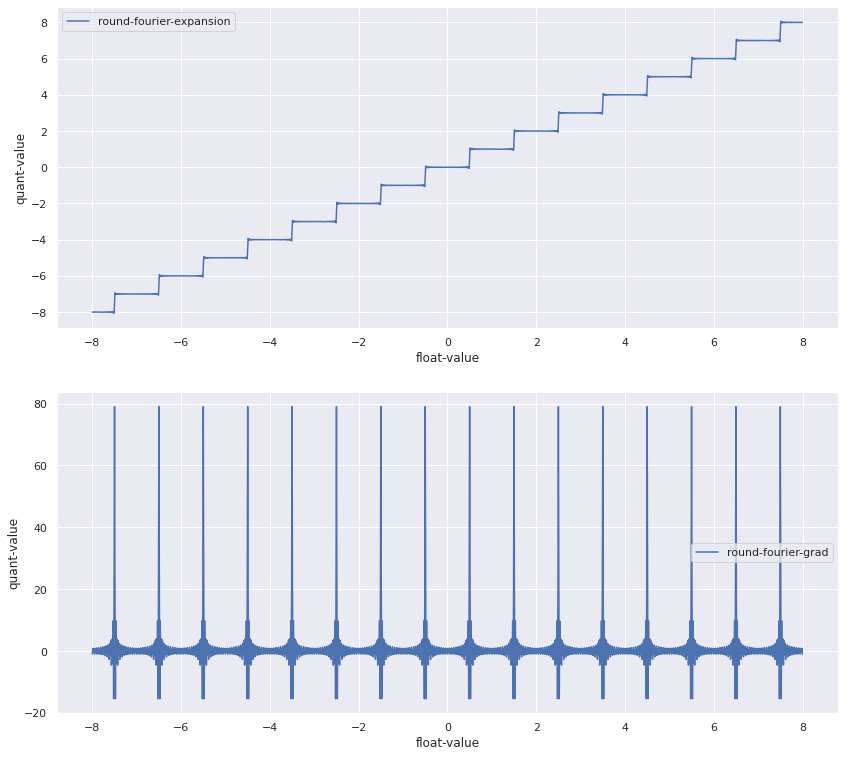

In [4]:
x = torch.range(-8, 8, 0.01, requires_grad=True)
y = round_fourier_forward.apply(x, 40)
res = y.sum().backward()

with sns.axes_style("darkgrid"):
    sns.set(rc={"figure.figsize": (14, 13)})
    
    subplot(2,1,1)
    df1 = pd.DataFrame( np.array(y.detach()), np.array(x.detach()), columns = ["round-fourier-expansion"])
    ax = sns.lineplot(data = df1)
    ax.set_ylabel("quant-value")
    ax.set_xlabel("float-value")
    
    subplot(2,1,2)
    df1 = pd.DataFrame( np.array(x.grad), np.array(x.detach()), columns = ["round-fourier-grad"])
    ax = sns.lineplot(data = df1)
    ax.set_ylabel("quant-value")
    ax.set_xlabel("float-value")

In [5]:
x.grad.max()

tensor(79.)

### 1.2 AdaptiveQAT

In [6]:
class ApdativeQAT(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, scale, lower_bound, upper_bound, stage = 8, coeff= 0.1):
        r"""
        LSQPlus: y = Round[clamp(x/s, n, p)] * s
        Args:
            x: input tensor
            scale: QAT scale
        return:
            x_quant: quantization tensor of x
        """
        x_hat = (x / scale).round()
        ctx.save_for_backward(x, x_hat, scale)
        ctx.constant = [lower_bound, upper_bound]
        x_hat = x_hat.clamp(lower_bound, upper_bound)
        x_quant = x_hat * scale
        quan_error = x - x_quant
        ctx.constant.append(quan_error)
        ctx.constant.append(stage)
        ctx.constant.append(coeff)
        return x_quant
    
    @staticmethod
    def backward(ctx, grad_output):
        r"""
        Backward:
            x_gradient: x[x > p or x < n] = 0 else 1
            scale_gradient: -(x - beta)/s + round[(x - beta)/s] else n or p
            beta_gradient: 0 or 1
        """
        x, x_hat, scale= ctx.saved_variables
        lower_bound, upper_bound, quant_error, stage,coeff = ctx.constant

        idx_smaller = ((x / scale).round() < lower_bound)
        idx_bigger = ((x /scale).round() > upper_bound)
        g_scale = 1.0 / math.sqrt(x.numel() * upper_bound) 

        r"""1. input gradient"""
        x_grad = torch.ones_like(grad_output)
        for n in range(1, int(stage)):
            x_grad += 2 * ((-1)**n ) * torch.cos(2 * math.pi * n * x)
        x_grad[idx_smaller] = 0
        x_grad[idx_bigger] = 0
        x_grad *= grad_output

        r"""2. scale gradient"""
        scale_grad = -x/scale + x_hat
        scale_grad[idx_smaller] = float(lower_bound)
        scale_grad[idx_bigger] = float(upper_bound)
        scale_grad = (scale_grad * grad_output).sum().unsqueeze(dim=0) * g_scale

        return x_grad, scale_grad, None, None, None

### 2. MSE Quant LOSS

In [23]:
import numpy as np
import torch
import random
from torch.nn.parameter import Parameter
import torch.nn.functional as F

nbits = 4
Qn = 0
Qp = 2 ** nbits - 1

beta = 0.1
iters = 2

target = torch.rand(2, 200, 50, 50)
target = torch.load('/data/workspace/QAT/lowbit_classification/data.pth')
add_offset = True
target_sum = torch.sum(target.clone(), 1)
#target_sum = target_sum - target_sum.mean()

alpha = Parameter((target.max() - target.min()) / (Qp - Qn) * 0.9)
offset = Parameter(torch.tensor(0.))

optimizer = torch.optim.SGD([alpha, offset], lr=0.01)

def dist(data, bins = 600):
    bin_size = (data.max() - data.min()) / bins
    hisc = data.detach().histc(bins = bins) / data.numel()
    xbin_idx = ((data - data.min()) / bin_size).floor().clamp(0, bins - 1)
    res = hisc[xbin_idx.long()]
    res = res/res.sum()
    return res

def grad_scale(x, scale):
    y = x
    y_grad = x * scale
    return y.detach() - y_grad.detach() + y_grad

#dist = dist(target)
dist_sum = dist(target_sum)

for t in range(iters):
    
    if add_offset:
            target_quant = ((target - offset)/alpha).clamp(Qn, Qp).round() * alpha + offset
    else:
        target_quant = (target/alpha).clamp(Qn, Qp).round() * alpha
    
    target_quant_sum = torch.sum(target_quant, 1)
    #target_quant_sum = target_quant_sum - target_quant_sum.mean()
    
    weight = torch.exp(target_sum.abs() * beta + dist_sum)
    weight = weight / weight.sum()
    #loss = ((target_sum - target_quant_sum)* weight).abs().sum()
    loss = F.kl_div(target_quant_sum/target_quant_sum.sum().log(), target_sum / target_sum.sum(), reduction='sum')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('*'*50,  alpha, offset)
    print('loss is:',loss)
    #break


************************************************** Parameter containing:
tensor(0.3029, requires_grad=True) Parameter containing:
tensor(0.0512, requires_grad=True)
loss is: tensor(-10.5200, grad_fn=<KlDivBackward>)
************************************************** Parameter containing:
tensor(0.3702, requires_grad=True) Parameter containing:
tensor(0.1024, requires_grad=True)
loss is: tensor(-10.5590, grad_fn=<KlDivBackward>)


### 3. Feature Map 

In [52]:
import math

nbits_w = 4
nbits_a = 4
signed = False

x = torch.load('/data/workspace/QAT/lowbit_classification/x.pth')
weight = torch.load('/data/workspace/QAT/lowbit_classification/weight.pth')

Qnw = -(2 ** (nbits_w - 1))
Qpw = 2 ** (nbits_w - 1) - 1
alpha_w = Parameter((weight.max() - weight.min()) / (Qpw - Qnw) * 0.9)
offset_w = Parameter(torch.tensor(0.))

if signed:
    Qna = -(2 ** (nbits_a - 1))
    Qpa = 2 ** (nbits_a - 1) - 1
else:
    Qna = 0
    Qpa = 2 ** nbits_a - 1
alpha_a = Parameter((x.max() - x.min()) / (Qpa - Qna) * 0.9)
offset_a = Parameter(torch.tensor(0.))

optimizer = torch.optim.SGD([alpha_w, offset_w, alpha_a, offset_a], lr=0.01)
beta = 0.1
iters = 150
res_target = F.conv2d(x, weight, None, (1, 1), (1, 1), (1, 1), 1)

def _quant_data(data, alpha, Qn, Qp, offset = None):
    if offset == None:
        return (data/alpha).clamp(Qn, Qp).round() * alpha
    else:
        return ((data - offset)/alpha).clamp(Qn, Qp).round() * alpha + offset

def dist(data, bins = 600):
    bin_size = (data.max() - data.min()) / bins
    hisc = data.detach().histc(bins = bins) / data.numel()
    xbin_idx = ((data - data.min()) / bin_size).floor().clamp(0, bins - 1)
    res = hisc[xbin_idx.long()]
    res = res/res.sum()
    return res

def grad_scale(x, scale):
    y = x
    y_grad = x * scale
    return y.detach() - y_grad.detach() + y_grad

dist = dist(res_target)

for _ in range(iters):
    
    g_a = 1.0 / math.sqrt(x.numel() * Qpa)
    g_w = 1.0 / math.sqrt(weight.numel() * Qpw)
    quant_w = _quant_data(weight, grad_scale(alpha_w, g_w), Qnw, Qpw, grad_scale(offset_w, g_w))
    quant_x = _quant_data(x,      grad_scale(alpha_a, g_a), Qna, Qpa, grad_scale(offset_a, g_a))

    res = F.conv2d(quant_x, quant_w, None, (1, 1), (1, 1), (1, 1), 1)
 
    loss = ((res - res_target.detach()) * torch.exp(beta* res_target.abs() * 0.1 + dist)).abs().mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('*'*50,  alpha_w, offset_w, alpha_a, offset_a)
    print('loss is:',loss)

************************************************** Parameter containing:
tensor(0.0883, requires_grad=True) Parameter containing:
tensor(0.0006, requires_grad=True) Parameter containing:
tensor(0.1687, requires_grad=True) Parameter containing:
tensor(-5.6095e-06, requires_grad=True)
loss is: tensor(0.2553, grad_fn=<MeanBackward0>)
************************************************** Parameter containing:
tensor(0.0882, requires_grad=True) Parameter containing:
tensor(0.0008, requires_grad=True) Parameter containing:
tensor(0.1686, requires_grad=True) Parameter containing:
tensor(-1.0022e-05, requires_grad=True)
loss is: tensor(0.2372, grad_fn=<MeanBackward0>)
************************************************** Parameter containing:
tensor(0.0881, requires_grad=True) Parameter containing:
tensor(0.0007, requires_grad=True) Parameter containing:
tensor(0.1686, requires_grad=True) Parameter containing:
tensor(-1.4004e-05, requires_grad=True)
loss is: tensor(0.2439, grad_fn=<MeanBackward0>)
*